# Comparative Analysis of Traffic Accident Hotspot Detection

Luke Zaruba, Bryan Runck

In [2]:
# Imports
import os

import contextily as ctx
import geopandas as gpd
import libpysal
import networkx
import numpy as np
import pandas as pd
import seaborn as sns
import spaghetti
import splot
from esda import G_Local, Moran_Local
from esda.adbscan import ADBSCAN, get_cluster_boundary
from matplotlib import pyplot as plt
from pysal.lib import weights
from sqlalchemy import URL, create_engine
from stco.clustering import TemporalADBSCAN
from stco.overlay import simple_overlay, stcec, weighted_overlay

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/

## Data

### Using Database

In [2]:
# Setup Database Credentials
# db_url = URL.create(
#     drivername="postgresql",
#     username=os.environ["DB_USER"],
#     password=os.environ["DB_PASSWORD"],
#     host=os.environ["DB_HOST"],
#     port=os.environ["DB_PORT"],
#     database=os.environ["DB_NAME"],
# )

# db = create_engine(db_url)

In [3]:
# Points
# incidents_gdf = gpd.read_postgis("SELECT * FROM geo_accidents_mn", db)

# incidents_gdf.head()

In [4]:
# Polygons
# ctu_gdf = gpd.read_postgis("SELECT * FROM ctu_accidents", db)

# ctu_gdf.head()

In [5]:
# Export
# incidents_gdf.to_file("../../data/core/INCIDENTS_DEC5.geojson", driver="GeoJSON")
# ctu_gdf.to_file("../../data/core/CTU_DEC5.geojson", driver="GeoJSON")

### Using Local Files

In [3]:
# Importing Points from GeoJSON
incidents_gdf = gpd.read_file("../../data/core/INCIDENTS_DEC5.geojson")

# incidents_gdf.head()

In [4]:
# Importing Polygons from GeoJSON
ctu_gdf = gpd.read_file("../../data/core/CTU_DEC5.geojson")

# ctu_gdf.head()

## Descriptive Statistics

### Maps

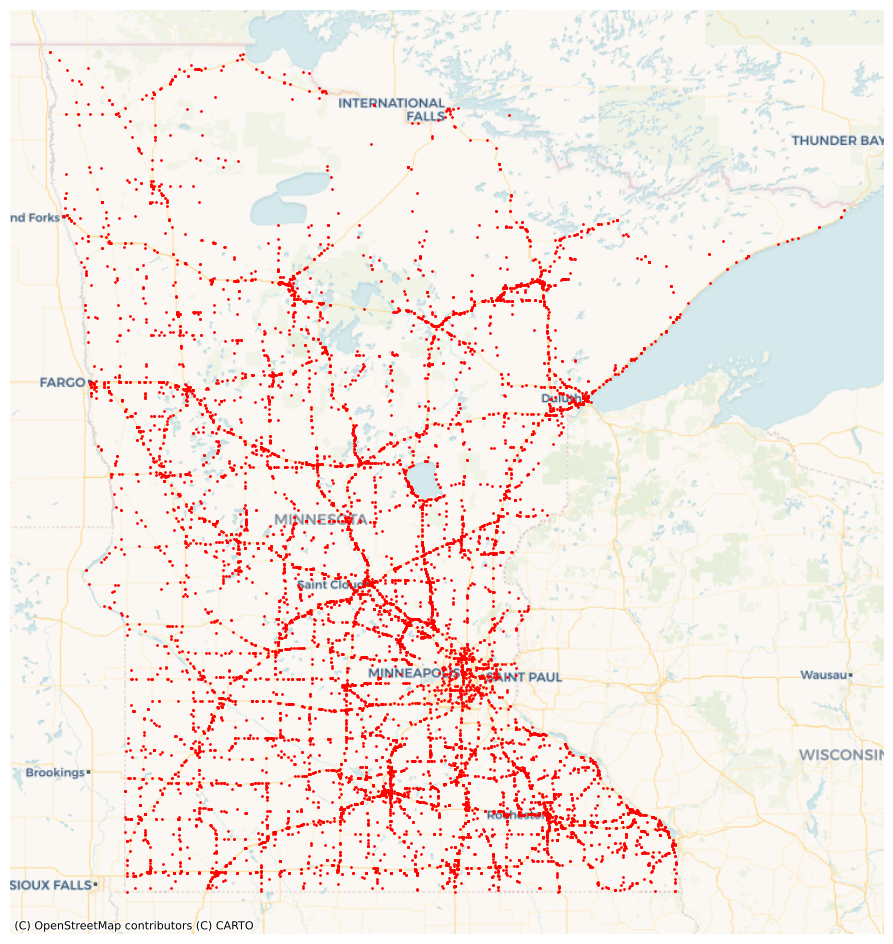

In [22]:
# Study Area Map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

incidents_gdf.to_crs(epsg=3857).plot(
    ax=ax, marker="o", color="red", markersize=1
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

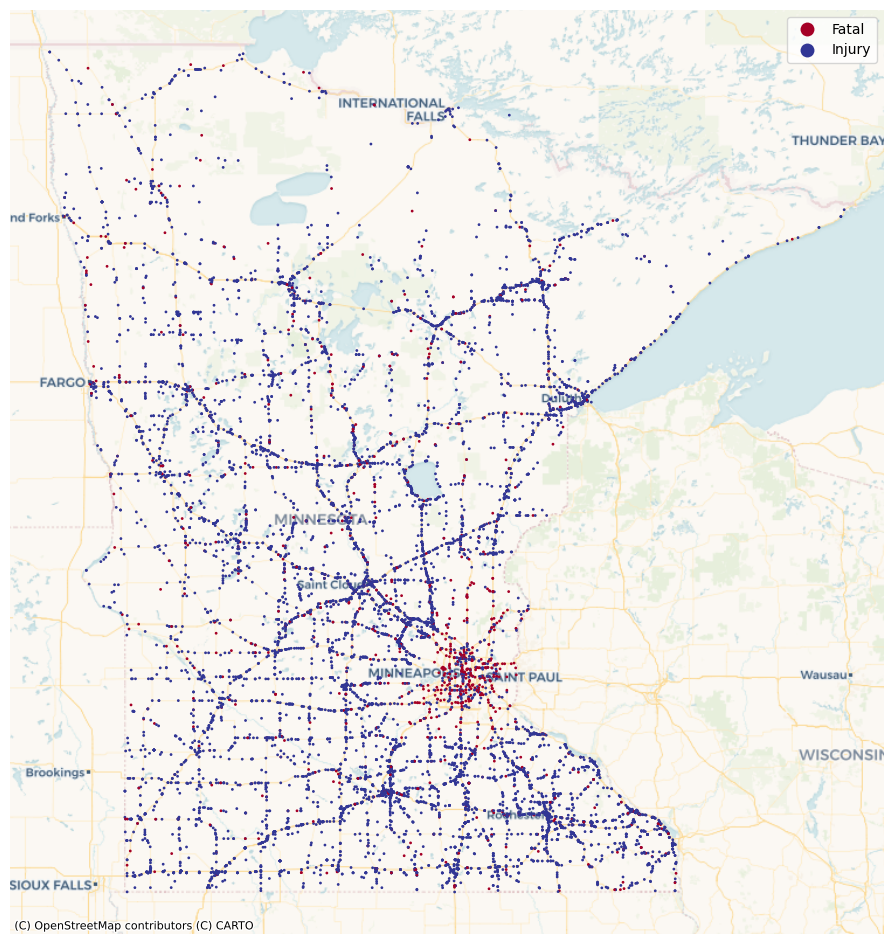

In [32]:
# Map of Accidents by Injury/Fatality
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

incidents_gdf.to_crs(epsg=3857).plot(
    ax=ax, column="incident_type", marker="o", markersize=1, legend=True, cmap="RdYlBu"
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()


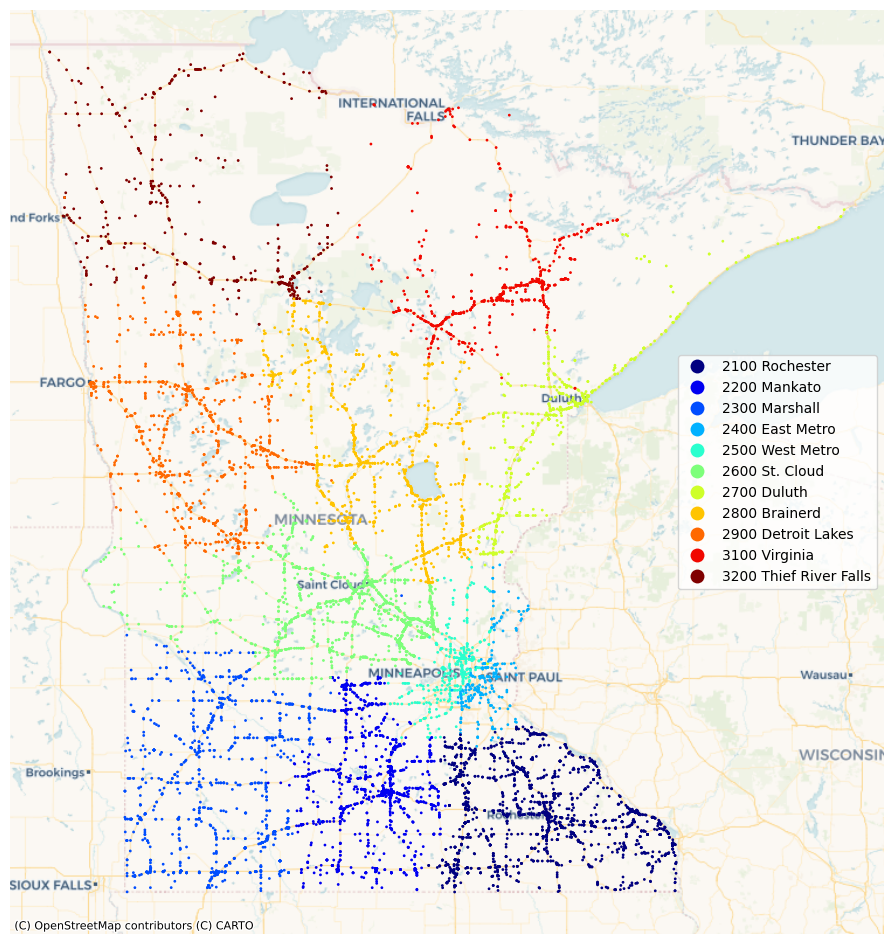

In [117]:
# Map of Accidents by District
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

incidents_gdf.to_crs(epsg=3857).plot(
    ax=ax, column="district", marker="o", markersize=1, legend=True, cmap="jet", legend_kwds={"loc": "center right"}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

### Tables

In [82]:
# Table of Accidents per Injury/Fatality
raw_acc_by_if = pd.DataFrame(incidents_gdf.groupby(by="incident_type")["icr"].count()).reset_index()
raw_acc_by_if["pct"] = round((raw_acc_by_if["icr"] / raw_acc_by_if["icr"].sum()) * 100, 1)
raw_acc_by_if.columns = ["Incident Type", "Frequency (n)", "Percent (%)"]

print(raw_acc_by_if.to_string(index=False))

Incident Type  Frequency (n)  Percent (%)
        Fatal           1126         10.9
       Injury           9217         89.1


In [83]:
# Table of Accidents per Road Condition
raw_acc_by_cond = pd.DataFrame(incidents_gdf.groupby(by="road_condition")["icr"].count()).iloc[1:].reset_index()
raw_acc_by_cond["pct"] = round((raw_acc_by_cond["icr"] / raw_acc_by_cond["icr"].sum()) * 100, 1)
raw_acc_by_cond.columns = ["Road Condition", "Frequency (n)", "Percent (%)"]

print(raw_acc_by_cond.to_string(index=False))

Road Condition  Frequency (n)  Percent (%)
           Dry           7318         70.8
         Other             42          0.4
      Snow/Ice           1984         19.2
           Wet            998          9.6


In [84]:
# Table of Accidents per Vehicles Involved
raw_acc_by_vi = pd.DataFrame(incidents_gdf.groupby(by="vehicles_involved")["icr"].count()).reset_index()
raw_acc_by_vi = raw_acc_by_vi[raw_acc_by_vi["vehicles_involved"] != 999]
raw_acc_by_vi["pct"] = round((raw_acc_by_vi["icr"] / raw_acc_by_vi["icr"].sum()) * 100, 2)
raw_acc_by_vi.columns = ["Number of Vehicles Involved", "Frequency (n)", "Percent (%)"]

print(raw_acc_by_vi.to_string(index=False))

 Number of Vehicles Involved  Frequency (n)  Percent (%)
                           1           4569        44.26
                           2           4971        48.16
                           3            603         5.84
                           4            128         1.24
                           5             30         0.29
                           6             13         0.13
                           7              4         0.04
                           8              1         0.01
                          10              2         0.02
                          12              1         0.01


In [86]:
# Table of Accident per District
raw_acc_by_di = pd.DataFrame(incidents_gdf.groupby(by="district")["icr"].count()).reset_index()
raw_acc_by_di["pct"] = round((raw_acc_by_di["icr"] / raw_acc_by_di["icr"].sum()) * 100, 2)
raw_acc_by_di.columns = ["MSP District", "Frequency (n)", "Percent (%)"]

print(raw_acc_by_di.to_string(index=False))

          MSP District  Frequency (n)  Percent (%)
        2100 Rochester           2016        19.49
          2200 Mankato           1296        12.53
         2300 Marshall           1016         9.82
       2400 East Metro            262         2.53
       2500 West Metro            358         3.46
        2600 St. Cloud           1583        15.31
           2700 Duluth            658         6.36
         2800 Brainerd           1081        10.45
    2900 Detroit Lakes            973         9.41
         3100 Virginia            658         6.36
3200 Thief River Falls            442         4.27


In [ ]:
# Table of Temporal Frequency by Season


In [108]:
# Table of Temporal Frequency by Month
raw_acc_by_mo = pd.DataFrame(incidents_gdf.groupby(by=[incidents_gdf.incident_date.dt.to_period("M").dt.strftime("%m")])["icr"].count()).reset_index()
raw_acc_by_mo["pct"] = round((raw_acc_by_mo["icr"] / raw_acc_by_mo["icr"].sum()) * 100, 2)
raw_acc_by_mo.columns = ["Month", "Frequency (n)", "Percent (%)"]

print(raw_acc_by_mo.to_string(index=False))

Month  Frequency (n)  Percent (%)
   01            956         9.24
   02            774         7.48
   03            714         6.90
   04            642         6.21
   05            824         7.97
   06            948         9.17
   07           1018         9.84
   08            948         9.17
   09            923         8.92
   10            892         8.62
   11            868         8.39
   12            836         8.08


In [109]:
# Table of Temporal Frequency by DoW - M, T, W, R, F, Sa, Su
raw_acc_by_dow = pd.DataFrame(incidents_gdf.groupby(by=[incidents_gdf.incident_date.dt.dayofweek])["icr"].count()).reset_index()
raw_acc_by_dow["pct"] = round((raw_acc_by_dow["icr"] / raw_acc_by_dow["icr"].sum()) * 100, 2)
raw_acc_by_dow.columns = ["Day of Week", "Frequency (n)", "Percent (%)"]

print(raw_acc_by_dow.to_string(index=False))

 Day of Week  Frequency (n)  Percent (%)
           0           1465        14.16
           1           1435        13.87
           2           1486        14.37
           3           1536        14.85
           4           1669        16.14
           5           1512        14.62
           6           1240        11.99


In [111]:
# Table of Temporal Frequency by HoD
raw_acc_by_hod = pd.DataFrame(incidents_gdf.groupby(by=[incidents_gdf.incident_date.dt.hour])["icr"].count()).reset_index()
raw_acc_by_hod["pct"] = round((raw_acc_by_hod["icr"] / raw_acc_by_hod["icr"].sum()) * 100, 2)
raw_acc_by_hod.columns = ["Hour of Day", "Frequency (n)", "Percent (%)"]

print(raw_acc_by_hod.to_string(index=False))

 Hour of Day  Frequency (n)  Percent (%)
           0            138         1.33
           1            158         1.53
           2            144         1.39
           3             95         0.92
           4            110         1.06
           5            219         2.12
           6            426         4.12
           7            534         5.16
           8            522         5.05
           9            518         5.01
          10            495         4.79
          11            590         5.70
          12            627         6.06
          13            660         6.38
          14            631         6.10
          15            727         7.03
          16            698         6.75
          17            751         7.26
          18            568         5.49
          19            455         4.40
          20            383         3.70
          21            364         3.52
          22            268         2.59
          23    

### Charts

#### Spider Charts

In [116]:
# Spider Chart of Accident Counts per Month
import plotly.express as px

fig = px.line_polar(raw_acc_by_mo, r="Frequency (n)", theta="Month", line_close=True)
fig.show()

In [ ]:
# Spider Chart of Accident Counts per Month by Road Condition

In [ ]:
# Spider Chart of Accident Counts per Month by District

In [ ]:
# Spider Chart of Accident Counts per Month by Fatal/Injury

#### Heat Maps

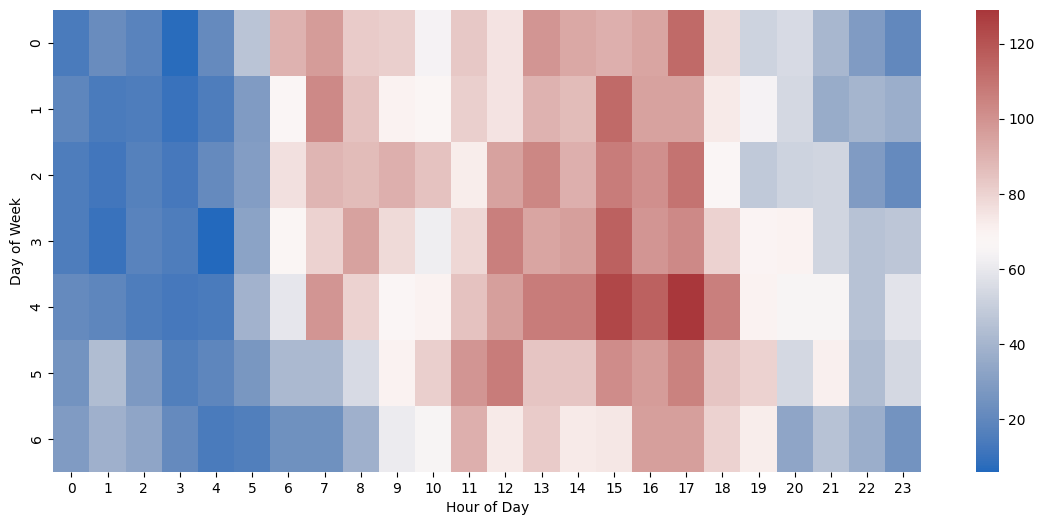

In [135]:
# Heat Map of Accident Counts per DoW and HoD
cluster_dow_hod = pd.DataFrame(incidents_gdf.groupby(by=[incidents_gdf.incident_date.dt.dayofweek.rename("DOW"), incidents_gdf.incident_date.dt.hour])["icr"].count()).reset_index()

cluster_dow_hod.columns = ["Day of Week", "Hour of Day", "Count"]

cluster_dow_hod = cluster_dow_hod.pivot(values = "Count", index = "Day of Week", columns = "Hour of Day")

fig, ax = plt.subplots(figsize=(14, 6))

sns.heatmap(cluster_dow_hod, cmap = "vlag", ax=ax);

In [ ]:
# Heat Map of Accident Counts per DoW and HoD by Road Condition

In [ ]:
# Heat Map of Accident Counts per DoW and HoD by District

In [ ]:
# Heat Map of Accident Counts per DoW and HoD by Fatal/Injury

## Polygons

### Local Indicators of Spatial Association (LISA)

For now, using already calculated data

In [5]:
# Standardize Data
ctu_gdf["total_road_length"] = ctu_gdf["total_road_length"].replace(0, 1)
    
ctu_gdf["rd_stdrd_incidents"] = (
    ctu_gdf["total_incident_count"] / ctu_gdf["total_road_length"]
)

In [6]:
# Set up LISA
data = ctu_gdf["rd_stdrd_incidents"].values

w = weights.Queen.from_dataframe(ctu_gdf)

In [ ]:
# Calculate LMI


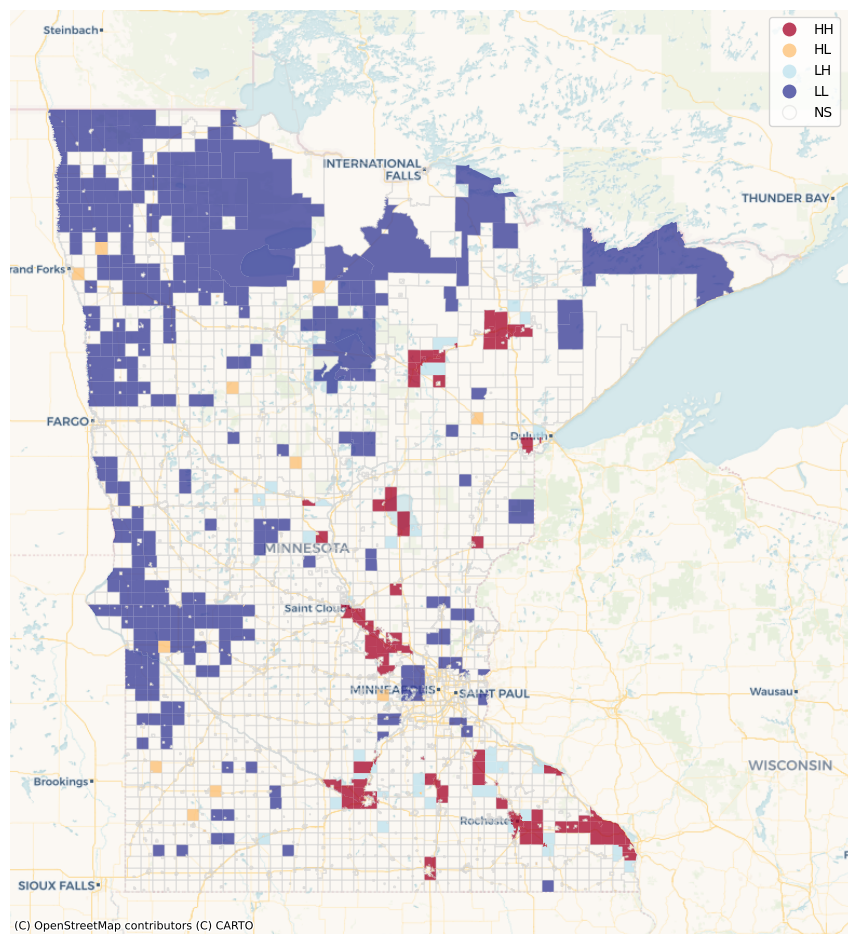

In [6]:
# Mapping LISA Results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ctu_gdf_plot = ctu_gdf.copy()

ctu_gdf_plot.loc[ctu_gdf_plot["lmi_label"] == "NS", "lmi_label"] = None

ctu_gdf_plot.to_crs(epsg=3857).plot(
    ax=ax,
    column="lmi_label",
    alpha=0.75,
    legend=True,
    cmap="RdYlBu",
    missing_kwds={
        "color": "none",
        "edgecolor": "lightgrey",
        "alpha": 0.4,
        "label": "NS",
    },
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

### Getis-Ord $G_{i}^{*}$

In [7]:
# Calculate Local Gi* Autocorrelation Statistic
gi_star = G_Local(data, w)

# Adding Columns
ctu_gdf["gi_star_z"] = gi_star.Zs
ctu_gdf["gi_star_p"] = gi_star.p_sim
ctu_gdf["gi_star_sig_05"] = 1 * (gi_star.p_sim < 0.05)
ctu_gdf["gi_star_sig_01"] = 1 * (gi_star.p_sim < 0.01)
ctu_gdf["gi_star_hot"] = 1 * (gi_star.Zs > 0)

# Labeling
ctu_gdf["gi_star_label_num"] = 0

for index, row in ctu_gdf.iterrows():
    if row["gi_star_sig_05"] == 1:
        ctu_gdf.loc[index, "gi_star_label_num"] = (2 * row["gi_star_hot"]) + row["gi_star_sig_05"] + row["gi_star_sig_01"]
        
labels = {
        0: "NS",
        1: "Coldspot, p < 0.05",
        2: "Coldspot, p < 0.01",
        3: "Hotspot, p < 0.05",
        4: "Hotspot, p < 0.01",
    }

ctu_gdf["gi_star_label"] = ctu_gdf["gi_star_label_num"].map(labels)

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/esda/crand.py:334: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/esda/crand.py:334: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  rstat

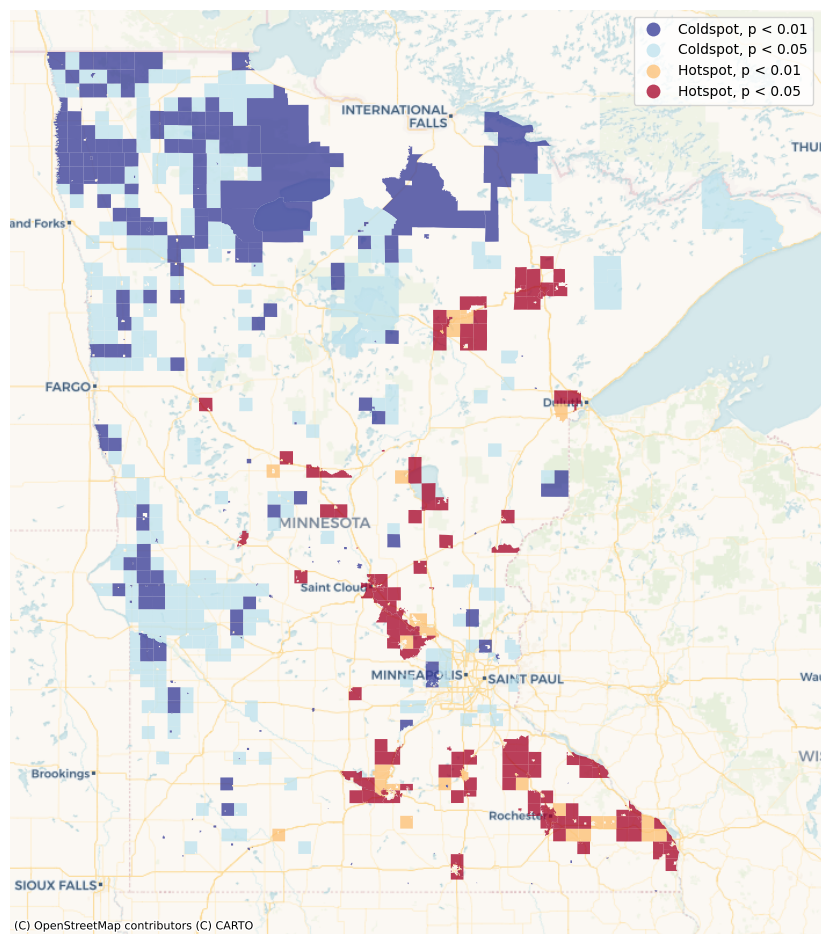

In [8]:
# Mapping Local Gi* Results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ctu_gdf_plot = ctu_gdf[ctu_gdf.gi_star_sig_05 > 0].copy()

ctu_gdf_plot.to_crs(epsg=3857).plot(
    ax=ax,
    column="gi_star_label",
    alpha=0.75,
    legend=True,
    cmap="RdYlBu_r"
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

## Lines

### Network-Constrained Spatial Autocorrelation (with LISA)

1. Queen's Contiguity - AADT
2. Queen's Contiguity - Road Length
3. Fuzzy Contiguity - AADT
4. Fuzzy Contiguity - Road Length


[See here](https://pysal.org/spaghetti/notebooks/network-spatial-autocorrelation.html)

**NOTE:** Spaghetti does not work well on this large of data

In [9]:
# Read in AADT Roads Dataset
aadt_gdf = gpd.read_file("../../data/core/Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp")

# Drop Unneeded Columns
aadt_gdf = aadt_gdf.drop([c for c in aadt_gdf.columns if c not in ["CURRENT_VO", "geometry"]], axis=1)

# Remove invalid features
aadt_gdf = aadt_gdf.loc[aadt_gdf["geometry"].is_valid]

aadt_gdf.head()

CURRENT_VO                                           geometry
0       629.0  LINESTRING (478576.969 5118194.000, 478975.563...
1      1712.0  LINESTRING (478576.969 5118194.000, 478583.625...
2      1192.0  LINESTRING (459579.563 5120185.000, 459606.157...
3      2712.0  LINESTRING (442104.938 5132530.499, 442228.657...
4      1109.0  LINESTRING (442104.938 5132530.499, 442193.531...

In [10]:
# Coordinate System Transform
incidents_gdf = incidents_gdf.to_crs(aadt_gdf.crs)

incidents_gdf.crs

<Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
# Spatial Joining Incidents to Roads
joined_aadt = gpd.sjoin_nearest(incidents_gdf, aadt_gdf)

joined_aadt = joined_aadt.drop_duplicates("icr")

# Aggregating
point_counts_aadt = joined_aadt.groupby("index_right").size().reset_index(name="point_count")

In [12]:
# Join Counts Back to Lines
aadt_gdf = aadt_gdf.merge(point_counts_aadt, left_index=True, right_on="index_right", how="left")

# Fill any NaN values (lines with no nearby points) with 0
aadt_gdf["point_count"] = aadt_gdf["point_count"].fillna(0)

# Drop unnecessary columns
aadt_gdf.drop(columns=["index_right"], inplace=True)

aadt_gdf = aadt_gdf.reset_index(drop=True)

# Calculate the length of each road segment
aadt_gdf["road_length"] = aadt_gdf["geometry"].length

# Normalize accident counts
aadt_gdf["acc_dnsty_length"] = aadt_gdf["point_count"] / aadt_gdf["road_length"]

aadt_gdf["acc_dnsty_aadt"] = aadt_gdf["point_count"] / aadt_gdf["CURRENT_VO"]

aadt_gdf.head()

CURRENT_VO                                           geometry  point_count  \
0       629.0  LINESTRING (478576.969 5118194.000, 478975.563...          4.0   
1      1712.0  LINESTRING (478576.969 5118194.000, 478583.625...          0.0   
2      1192.0  LINESTRING (459579.563 5120185.000, 459606.157...          2.0   
3      2712.0  LINESTRING (442104.938 5132530.499, 442228.657...          1.0   
4      1109.0  LINESTRING (442104.938 5132530.499, 442193.531...          7.0   

    road_length  acc_dnsty_length  acc_dnsty_aadt  
0  21544.491854          0.000186        0.006359  
1   2644.750045          0.000000        0.000000  
2  11354.308303          0.000176        0.001678  
3   6587.415813          0.000152        0.000369  
4  20312.608090          0.000345        0.006312

In [13]:
# Weights - Queens
aadt_wq = weights.Queen.from_dataframe(aadt_gdf)

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 990 disconnected components.
 There are 811 islands with ids: 1842, 3332, 5222, 6241, 6343, 7184, 9789, 9864, 10056, 10114, 10115, 10211, 11363, 11395, 11731, 12572, 12902, 12911, 13518, 14280, 14362, 14370, 15801, 16241, 16676, 16691, 17605, 18225, 18279, 18409, 18478, 20059, 20493, 20634, 20641, 20644, 20645, 20659, 20660, 20661, 20690, 20691, 20693, 20695, 21029, 21036, 21704, 21857, 22231, 22302, 22357, 22361, 22725, 22738, 22824, 23063, 24275, 24368, 25852, 27046, 27054, 27323, 27566, 27614, 27659, 27660, 27718, 27726, 27730, 27757, 27760, 27779, 27783, 27792, 27793, 27795, 27797, 27814, 27828, 27909, 28025, 28232, 28457, 28475, 28546, 28695, 28699, 28731, 28834, 28892, 28935, 29490, 29514, 29791, 29803, 30018, 30259, 30455, 30467, 30517, 30670, 30731, 30780, 30830, 30889, 31056, 31076, 31077, 31312, 3136

In [14]:
# Weights - Fuzzy Contiguity
aadt_wfc = weights.fuzzy_contiguity(aadt_gdf)

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/weights/util.py:1665: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = gdf.sindex.query_bulk(gdf.geometry, predicate=predicate)
/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 682 disconnected components.
 There are 599 islands with ids: 3332, 6343, 7184, 9789, 9864, 10114, 10115, 10211, 11363, 11395, 11731, 12572, 12902, 12911, 13518, 14280, 14362, 14370, 15801, 16241, 16676, 16691, 17605, 18225, 18478, 20634, 20645, 20660, 20661, 20691, 20695, 21029, 21036, 21704, 22231, 22361, 22725, 22738, 27046, 27054, 27323, 27566, 27614, 27659, 27660, 27718, 27726, 27730, 27757, 27760, 27779, 27783, 27792, 27793, 27795, 27797, 27814, 27909, 28025, 28232, 28457, 28475, 28546, 28695, 28

#### Queen's: AADT

('WARNING: ', 1842, ' is an island (no neighbors)')
('WARNING: ', 3332, ' is an island (no neighbors)')
('WARNING: ', 5222, ' is an island (no neighbors)')
('WARNING: ', 6241, ' is an island (no neighbors)')
('WARNING: ', 6343, ' is an island (no neighbors)')
('WARNING: ', 7184, ' is an island (no neighbors)')
('WARNING: ', 9789, ' is an island (no neighbors)')
('WARNING: ', 9864, ' is an island (no neighbors)')
('WARNING: ', 10056, ' is an island (no neighbors)')
('WARNING: ', 10114, ' is an island (no neighbors)')
('WARNING: ', 10115, ' is an island (no neighbors)')
('WARNING: ', 10211, ' is an island (no neighbors)')
('WARNING: ', 11363, ' is an island (no neighbors)')
('WARNING: ', 11395, ' is an island (no neighbors)')
('WARNING: ', 11731, ' is an island (no neighbors)')
('WARNING: ', 12572, ' is an island (no neighbors)')
('WARNING: ', 12902, ' is an island (no neighbors)')
('WARNING: ', 12911, ' is an island (no neighbors)')
('WARNING: ', 13518, ' is an island (no neighbors)')
(

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


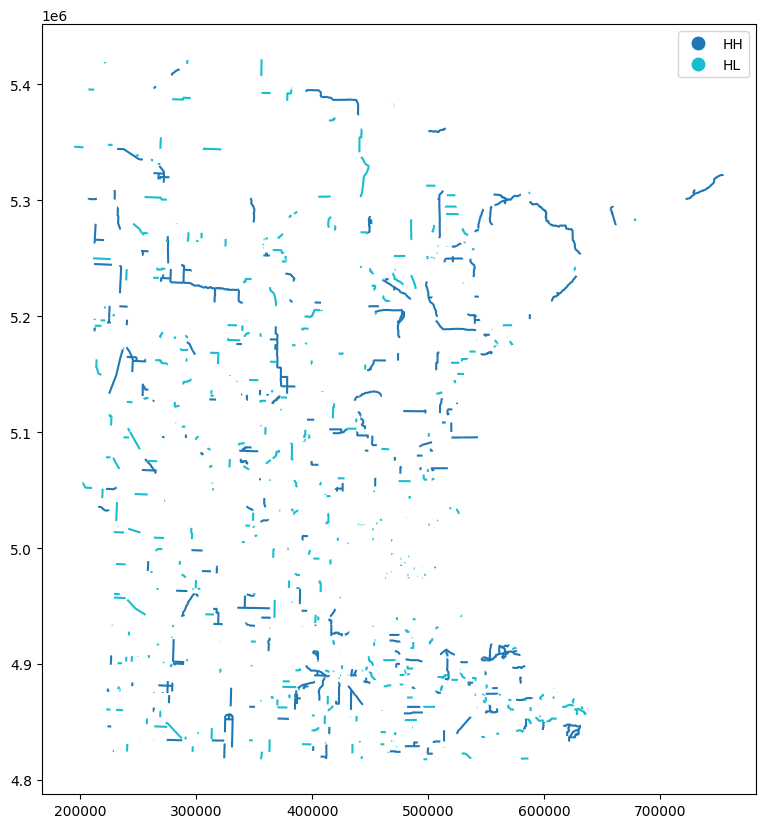

In [15]:
# Extract the points count as a NumPy array
data = aadt_gdf["acc_dnsty_aadt"].values

# Perform Local Moran"s I analysis
moran_loc = Moran_Local(data, aadt_wq)

# Add the Local Moran"s I values and p-values as columns in the GeoDataFrame
# aadt_gdf["lmi_i"] = moran_loc.Is
# aadt_gdf["lmi_p"] = moran_loc.p_sim
# aadt_gdf["lmi_sig"] = 1 * (moran_loc.p_sim < 0.05)
# aadt_gdf["lmi_q"] = moran_loc.q

# LABELS
labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column with labels for each polygon
aadt_gdf["q_aadt_lmi_label"] = pd.Series(
    moran_loc.q * (1 * (moran_loc.p_sim < 0.05)),
    index=aadt_gdf.index
).map(labels)

# Plot
aadt_gdf.loc[(aadt_gdf.q_aadt_lmi_label == "HH") | (aadt_gdf.q_aadt_lmi_label == "HL")].plot(column="q_aadt_lmi_label", legend=True, figsize=(10,10));

#### Queen's: Road Length

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


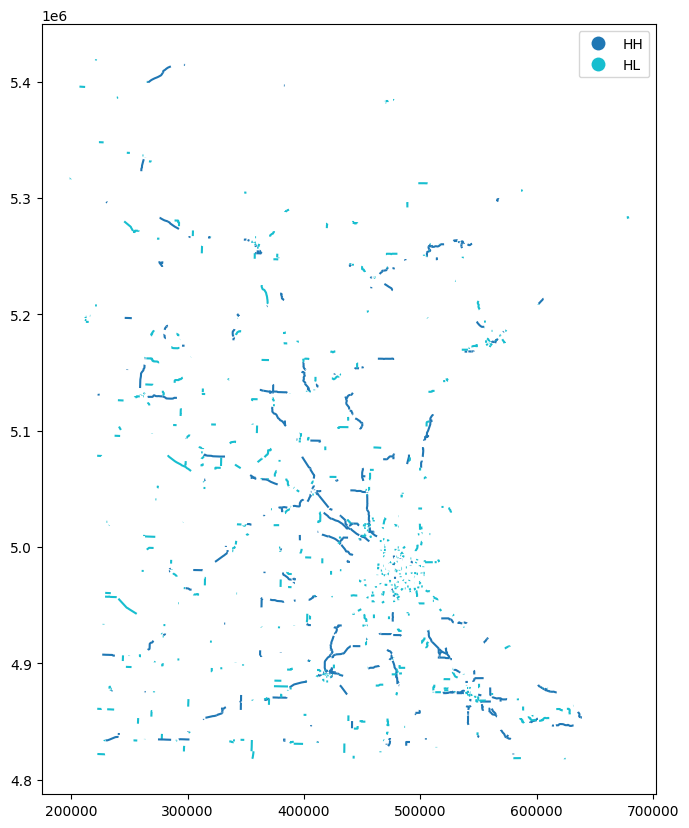

In [16]:
# Extract the points count as a NumPy array
data = aadt_gdf["acc_dnsty_length"].values

# Perform Local Moran"s I analysis
moran_loc = Moran_Local(data, aadt_wq)

# Add the Local Moran"s I values and p-values as columns in the GeoDataFrame
# aadt_gdf["lmi_i"] = moran_loc.Is
# aadt_gdf["lmi_p"] = moran_loc.p_sim
# aadt_gdf["lmi_sig"] = 1 * (moran_loc.p_sim < 0.05)
# aadt_gdf["lmi_q"] = moran_loc.q

# LABELS
labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
aadt_gdf["q_rl_lmi_label"] = pd.Series(
    moran_loc.q * (1 * (moran_loc.p_sim < 0.05)),
    index=aadt_gdf.index
).map(labels)

# Plot
aadt_gdf.loc[(aadt_gdf.q_rl_lmi_label == "HH") | (aadt_gdf.q_rl_lmi_label == "HL")].plot(column="q_rl_lmi_label", legend=True, figsize=(10,10));

#### Fuzzy: AADT

('WARNING: ', 3332, ' is an island (no neighbors)')
('WARNING: ', 6343, ' is an island (no neighbors)')
('WARNING: ', 7184, ' is an island (no neighbors)')
('WARNING: ', 9789, ' is an island (no neighbors)')
('WARNING: ', 9864, ' is an island (no neighbors)')
('WARNING: ', 10114, ' is an island (no neighbors)')
('WARNING: ', 10115, ' is an island (no neighbors)')
('WARNING: ', 10211, ' is an island (no neighbors)')
('WARNING: ', 11363, ' is an island (no neighbors)')
('WARNING: ', 11395, ' is an island (no neighbors)')
('WARNING: ', 11731, ' is an island (no neighbors)')
('WARNING: ', 12572, ' is an island (no neighbors)')
('WARNING: ', 12902, ' is an island (no neighbors)')
('WARNING: ', 12911, ' is an island (no neighbors)')
('WARNING: ', 13518, ' is an island (no neighbors)')
('WARNING: ', 14280, ' is an island (no neighbors)')
('WARNING: ', 14362, ' is an island (no neighbors)')
('WARNING: ', 14370, ' is an island (no neighbors)')
('WARNING: ', 15801, ' is an island (no neighbors)'

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


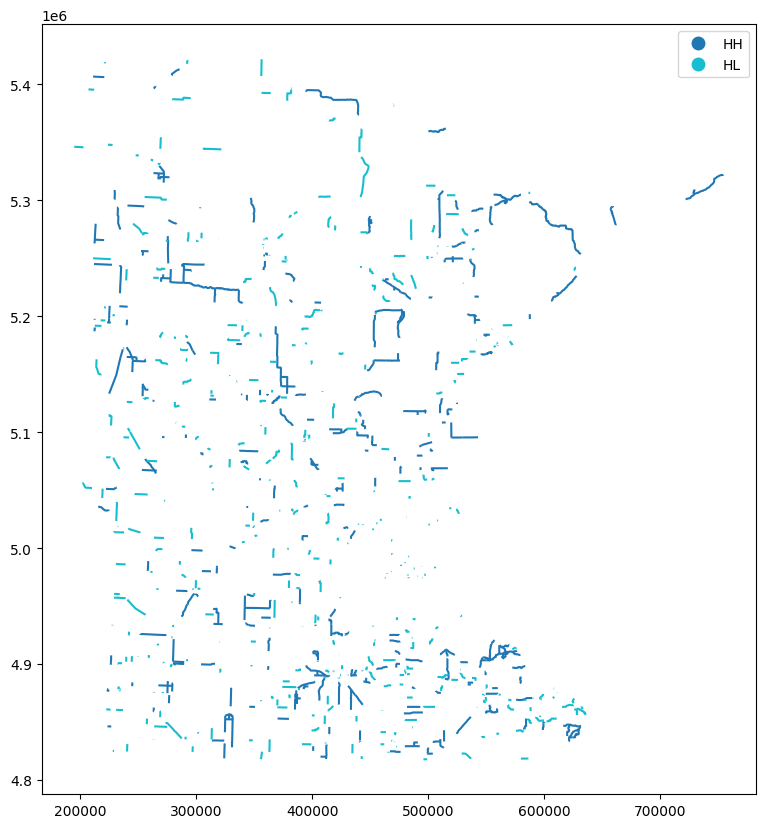

In [17]:
# Extract the points count as a NumPy array
data = aadt_gdf["acc_dnsty_aadt"].values

# Perform Local Moran"s I analysis
moran_loc = Moran_Local(data, aadt_wfc)

# Add the Local Moran"s I values and p-values as columns in the GeoDataFrame
# aadt_gdf["lmi_i"] = moran_loc.Is
# aadt_gdf["lmi_p"] = moran_loc.p_sim
# aadt_gdf["lmi_sig"] = 1 * (moran_loc.p_sim < 0.05)
# aadt_gdf["lmi_q"] = moran_loc.q

# LABELS
labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
aadt_gdf["f_aadt_lmi_label"] = pd.Series(
    moran_loc.q * (1 * (moran_loc.p_sim < 0.05)),
    index=aadt_gdf.index
).map(labels)

# Plot
aadt_gdf.loc[(aadt_gdf.f_aadt_lmi_label == "HH") | (aadt_gdf.f_aadt_lmi_label == "HL")].plot(column="f_aadt_lmi_label", legend=True, figsize=(10,10));

#### Fuzzy: Road Length

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


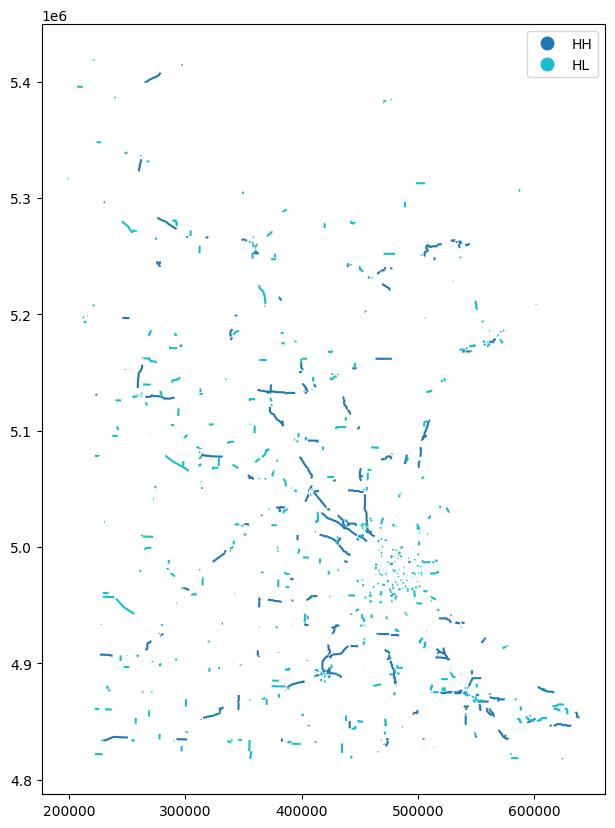

In [18]:
# Extract the points count as a NumPy array
data = aadt_gdf["acc_dnsty_length"].values

# Perform Local Moran's I analysis
moran_loc = Moran_Local(data, aadt_wfc)

# Add the Local Moran's I values and p-values as columns in the GeoDataFrame
# aadt_gdf["lmi_i"] = moran_loc.Is
# aadt_gdf["lmi_p"] = moran_loc.p_sim
# aadt_gdf["lmi_sig"] = 1 * (moran_loc.p_sim < 0.05)
# aadt_gdf["lmi_q"] = moran_loc.q

# LABELS
labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
aadt_gdf["f_rl_lmi_label"] = pd.Series(
    moran_loc.q * (1 * (moran_loc.p_sim < 0.05)),
    index=aadt_gdf.index
).map(labels)

# Plot
aadt_gdf.loc[(aadt_gdf.f_rl_lmi_label == "HH") | (aadt_gdf.f_rl_lmi_label == "HL")].plot(column="f_rl_lmi_label", legend=True, figsize=(10,10));

## Points

### A-DBSCAN

In [19]:
# CRS
incidents_gdf = incidents_gdf.to_crs(4326)

# Get XY Coordinates
incidents_gdf["X"] = incidents_gdf.geometry.x
incidents_gdf["Y"] = incidents_gdf.geometry.y

# Get clusters
adbs = ADBSCAN(
    0.15, incidents_gdf.shape[0] * 0.01, pct_exact=0.5, reps=50, keep_solus=True
)
adbs.fit(incidents_gdf)

# Get Footprints
adbs_polys = get_cluster_boundary(
    adbs.votes["lbls"], incidents_gdf, crs=incidents_gdf.crs
)

data = {"geometry": adbs_polys}

adbs_footprints = gpd.GeoDataFrame(data)

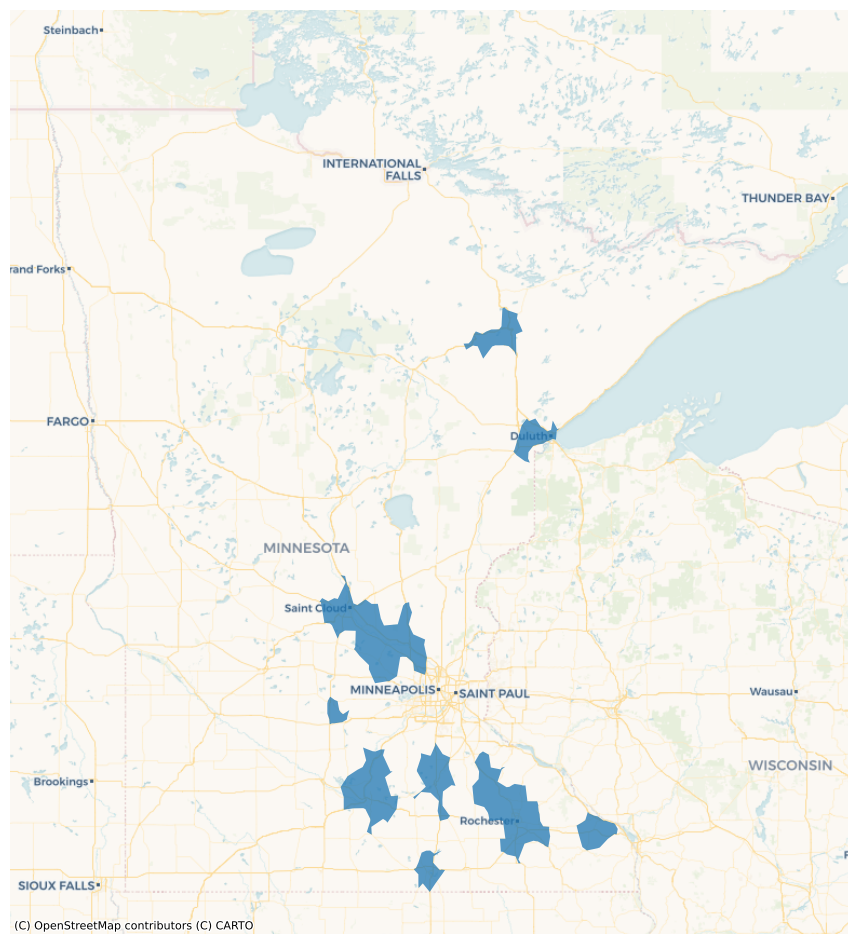

In [20]:
# Mapping A-DBSCAN Results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ctu_gdf.to_crs(epsg=3857).plot(
    ax=ax,
    alpha=0
)

adbs_footprints.to_crs(epsg=3857).plot(
    ax=ax,
    alpha=0.75,
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

### STCO: Simple

In [23]:
# Create ADBSCAN Clusters per Year
tadbs = TemporalADBSCAN(
    data=incidents_gdf,
    period="Y",
    eps=0.15,
    min_sample_pct=0.01,
    time_field="incident_date",
    pct_exact=0.5,
    reps=50,
    keep_solus=True,
)

tadbs_clusters = tadbs.fit_all()

tadbs_clusters.head()

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


PERIOD                                           geometry
1    2020  POLYGON ((-92.23088 46.75161, -92.15044 46.788...
16   2020  POLYGON ((-94.97406 45.88946, -94.87256 45.875...
2    2020  POLYGON ((-92.58501 44.41688, -92.51114 44.325...
21   2020  POLYGON ((-93.46615 43.52854, -93.49341 43.676...
3    2020  POLYGON ((-93.43934 44.23364, -93.44938 44.230...

In [24]:
# Simple Overlay
stco_so = simple_overlay(tadbs_clusters.copy())

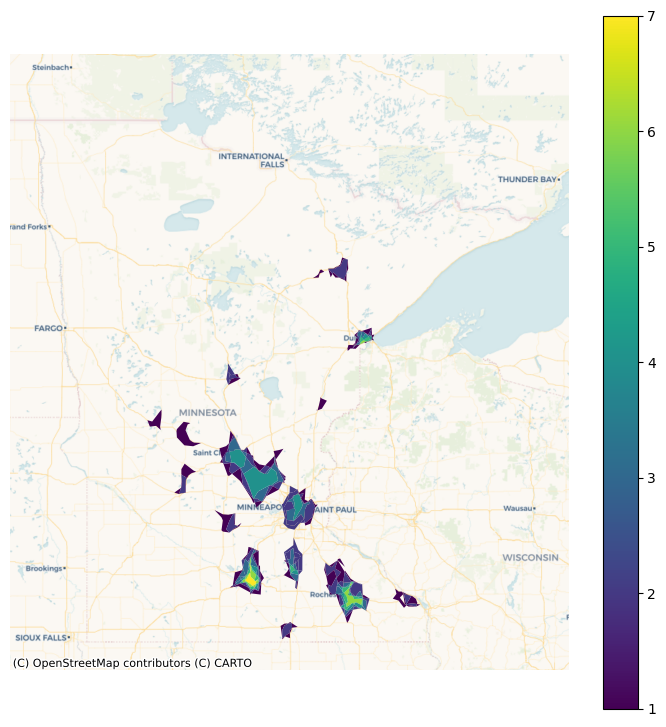

In [27]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

stco_so = stco_so.set_crs(epsg=4326)
stco_so.to_crs(epsg=3857).plot(column="COUNT", legend=True, ax=ax)
ctu_gdf.to_crs(epsg=3857).plot(alpha=0, ax=ax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

### STCO: Weighted

In [28]:
# Weighted Overlay
stco_wo = weighted_overlay(tadbs_clusters.copy())

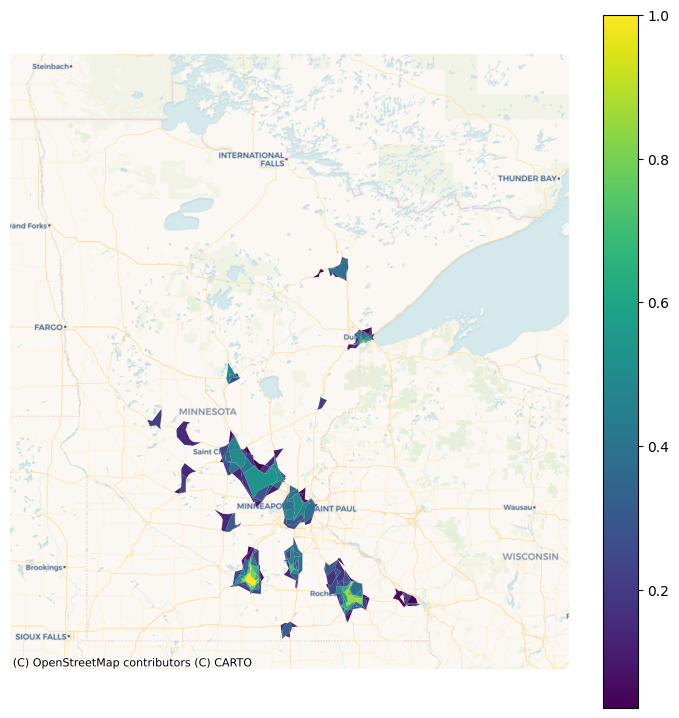

In [29]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

stco_wo = stco_wo.set_crs(epsg=4326)
stco_wo.to_crs(epsg=3857).plot(column="WEIGHT", legend=True, ax=ax)
ctu_gdf.to_crs(epsg=3857).plot(alpha=0, ax=ax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

### STCEC

In [30]:
# STCEC
stcec_classes = stcec(tadbs_clusters.copy(), significance_percent=0.8)

KeyError: 115 not found
KeyError: 232 not found
KeyError: 431 not found


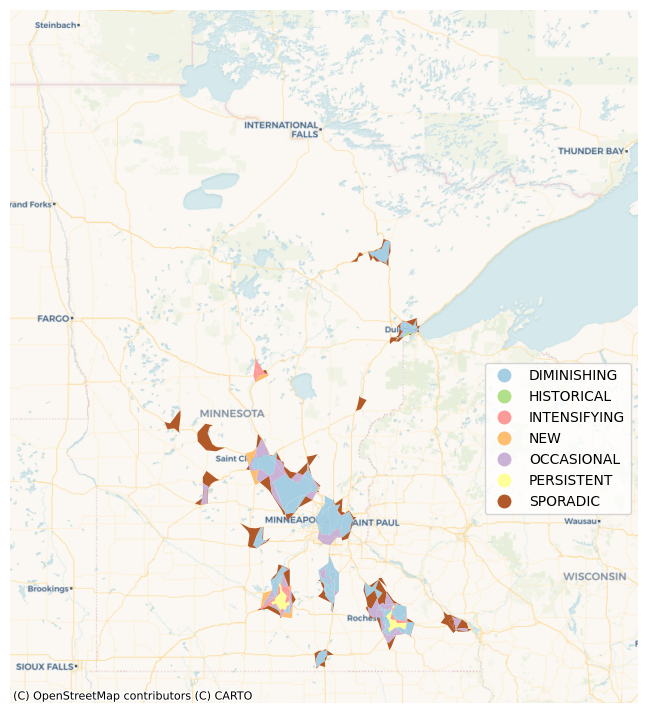

In [33]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

stcec_classes = stcec_classes.set_crs(epsg=4326)
stcec_classes.to_crs(epsg=3857).plot(
    column="STCEC",
    cmap="Paired",
    legend=True,
    ax=ax,
    legend_kwds={"bbox_to_anchor": (1, 0.5)},
)
ctu_gdf.to_crs(epsg=3857).plot(alpha=0, ax=ax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

## Verification

### Statewide Fishnet Creation

In [21]:
# Transform CRS
ctu_gdf = ctu_gdf.to_crs(3857)

ctu_gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
# Find Bounds
xmin, ymin, xmax, ymax = ctu_gdf.total_bounds

print(xmin, ymin, xmax, ymax)

-10824606.353575652 5388302.941234957 -9962177.457852405 6340228.568817256


In [23]:
# Settings
grid_size = 1609.34 * 5 # meters -> ~5 miles
rows = int(np.ceil((ymax - ymin) /  grid_size))
cols = int(np.ceil((xmax - xmin) / grid_size))

left = xmin
right = xmin + grid_size
top = ymax
bottom = ymax - grid_size

print(rows, cols)

119 108


In [24]:
from shapely.geometry import Polygon

polygons = []
for i in range(cols):
    Ytop = top
    Ybottom = bottom
    for j in range(rows):
        polygons.append(Polygon([(left, Ytop), (right, Ytop), (right, Ybottom), (left, Ybottom)])) 
        Ytop -= grid_size
        Ybottom -= grid_size
    left += grid_size
    right += grid_size
    
grid = gpd.GeoDataFrame({"geometry":polygons}, crs=3857)

In [25]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# grid.boundary.plot(
#     ax=ax,
#     alpha=0.5,
#     edgecolor="black",
#     linewidth=0.1,
# )
# ctu_gdf.boundary.plot(ax=ax,
#     alpha=0.5,
#     edgecolor="red",
#     linewidth=0.1)

# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# ax.axis("off")
# plt.show()

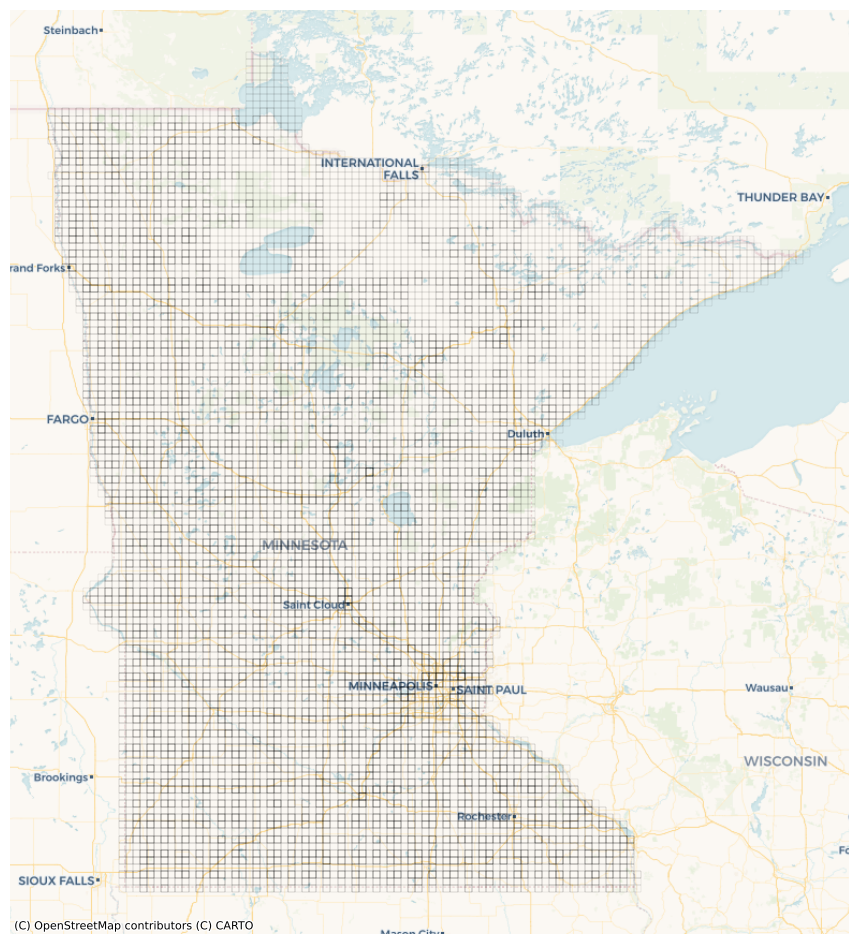

In [25]:
# Filter out Grid Cells
grid_ctu_sjoin = gpd.sjoin(grid, ctu_gdf)

grid = grid.loc[grid_ctu_sjoin.index]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

grid.boundary.plot(
    ax=ax,
    alpha=0.5,
    edgecolor="black",
    linewidth=0.1,
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

### Grid Assignments for Methods

In [26]:
# Reset Index
grid.reset_index(inplace=True, drop=True)
grid.reset_index(inplace=True)

grid.head()

index                                           geometry
0      0  POLYGON ((-10824606.354 6275854.969, -10816559...
1      1  POLYGON ((-10824606.354 6267808.269, -10816559...
2      2  POLYGON ((-10824606.354 6259761.569, -10816559...
3      3  POLYGON ((-10816559.654 6275854.969, -10808512...
4      4  POLYGON ((-10816559.654 6267808.269, -10808512...

#### LISA: Binary

In [27]:
# Joining LISA to Grid
lisa_hotspots = ctu_gdf.loc[(ctu_gdf.lmi_label == "HH") | (ctu_gdf.lmi_label == "HL")]
lisa_grid = gpd.sjoin(grid, lisa_hotspots)

In [28]:
# Aggregating
grid["LISA_Binary"] = 0

for i in list(lisa_grid.index):
    grid.at[i, "LISA_Binary"] = 1

#### LISA: Area (%)

In [29]:
# Intersection
lisa_intersection = gpd.overlay(grid, lisa_hotspots, how="intersection")

# Area Calculation
lisa_intersection["int_area"] = lisa_intersection.geometry.area

In [30]:
# Aggregating
grid_aggregated = lisa_intersection.groupby("index")["int_area"].sum()

grid = grid.merge(grid_aggregated, how="left", left_index=True, right_on="index")

grid["int_area"] = grid["int_area"].fillna(0)

grid = grid.set_index("index", drop=False)

grid["LISA_Area_Pct"] = grid["int_area"] / grid.geometry.area * 100

grid = grid.drop(columns=["int_area"])

#### Network LISA: Binary (Queen's: AADT)

In [31]:
# CRS
aadt_gdf = aadt_gdf.to_crs(3857)

In [32]:
# Joining Network LISA to Grid
nwk_lisa_hotspots = aadt_gdf.loc[(aadt_gdf.q_aadt_lmi_label == "HH") | (aadt_gdf.q_aadt_lmi_label == "HL")]
nwk_lisa_grid = gpd.sjoin(grid, nwk_lisa_hotspots)

In [33]:
# Aggregating
grid["Nwk_LISA_Binary_q_aadt"] = 0

for i in list(nwk_lisa_grid.index):
    grid.at[i, "Nwk_LISA_Binary_q_aadt"] = 1

#### Network LISA: Length (Queen's: AADT)

In [34]:
# Intersection
nwk_lisa_intersection = gpd.overlay(nwk_lisa_hotspots, grid, how="intersection")

# Area Calculation
nwk_lisa_intersection["Network_LISA_Len_q_aadt"] = nwk_lisa_intersection.geometry.length

In [35]:
# Aggregating
nwk_lisa_grid_aggregated = nwk_lisa_intersection.groupby("index")["Network_LISA_Len_q_aadt"].sum()

grid = grid.merge(nwk_lisa_grid_aggregated, how="left", left_index=True, right_on="index")

grid["Network_LISA_Len_q_aadt"] = grid["Network_LISA_Len_q_aadt"].fillna(0)

grid = grid.set_index("index", drop=False)

#### Network LISA: Binary (Queen's Road Length)

In [36]:
# Joining Network LISA to Grid
nwk_lisa_hotspots = aadt_gdf.loc[(aadt_gdf.q_rl_lmi_label == "HH") | (aadt_gdf.q_rl_lmi_label == "HL")]
nwk_lisa_grid = gpd.sjoin(grid, nwk_lisa_hotspots)

In [37]:
# Aggregating
grid["Nwk_LISA_Binary_q_rl"] = 0

for i in list(nwk_lisa_grid.index):
    grid.at[i, "Nwk_LISA_Binary_q_rl"] = 1

#### Network LISA: Length (Queen's Road Length)

In [38]:
# Intersection
nwk_lisa_intersection = gpd.overlay(nwk_lisa_hotspots, grid, how="intersection")

# Area Calculation
nwk_lisa_intersection["Network_LISA_Len_q_rl"] = nwk_lisa_intersection.geometry.length

In [39]:
# Aggregating
nwk_lisa_grid_aggregated = nwk_lisa_intersection.groupby("index")["Network_LISA_Len_q_rl"].sum()

grid = grid.merge(nwk_lisa_grid_aggregated, how="left", left_index=True, right_on="index")

grid["Network_LISA_Len_q_rl"] = grid["Network_LISA_Len_q_rl"].fillna(0)

grid = grid.set_index("index", drop=False)

#### Network LISA: Binary (Fuzzy AADT)

In [40]:
# Joining Network LISA to Grid
nwk_lisa_hotspots = aadt_gdf.loc[(aadt_gdf.f_aadt_lmi_label == "HH") | (aadt_gdf.f_aadt_lmi_label == "HL")]
nwk_lisa_grid = gpd.sjoin(grid, nwk_lisa_hotspots)

In [41]:
# Aggregating
grid["Nwk_LISA_Binary_f_aadt"] = 0

for i in list(nwk_lisa_grid.index):
    grid.at[i, "Nwk_LISA_Binary_f_aadt"] = 1

#### Network LISA: Length (Fuzzy AADT)

In [42]:
# Intersection
nwk_lisa_intersection = gpd.overlay(nwk_lisa_hotspots, grid, how="intersection")

# Area Calculation
nwk_lisa_intersection["Network_LISA_Len_f_aadt"] = nwk_lisa_intersection.geometry.length

In [43]:
# Aggregating
nwk_lisa_grid_aggregated = nwk_lisa_intersection.groupby("index")["Network_LISA_Len_f_aadt"].sum()

grid = grid.merge(nwk_lisa_grid_aggregated, how="left", left_index=True, right_on="index")

grid["Network_LISA_Len_f_aadt"] = grid["Network_LISA_Len_f_aadt"].fillna(0)

grid = grid.set_index("index", drop=False)

#### Network LISA: Binary (Fuzzy Road Length)

In [44]:
# Joining Network LISA to Grid
nwk_lisa_hotspots = aadt_gdf.loc[(aadt_gdf.f_rl_lmi_label == "HH") | (aadt_gdf.f_rl_lmi_label == "HL")]
nwk_lisa_grid = gpd.sjoin(grid, nwk_lisa_hotspots)

In [45]:
# Aggregating
grid["Nwk_LISA_Binary_f_rl"] = 0

for i in list(nwk_lisa_grid.index):
    grid.at[i, "Nwk_LISA_Binary_f_rl"] = 1

#### Network LISA: Length (Fuzzy Road Length)

In [46]:
# Intersection
nwk_lisa_intersection = gpd.overlay(nwk_lisa_hotspots, grid, how="intersection")

# Area Calculation
nwk_lisa_intersection["Network_LISA_Len_f_rl"] = nwk_lisa_intersection.geometry.length

In [47]:
# Aggregating
nwk_lisa_grid_aggregated = nwk_lisa_intersection.groupby("index")["Network_LISA_Len_f_rl"].sum()

grid = grid.merge(nwk_lisa_grid_aggregated, how="left", left_index=True, right_on="index")

grid["Network_LISA_Len_f_rl"] = grid["Network_LISA_Len_f_rl"].fillna(0)

grid = grid.set_index("index", drop=False)

#### A-DBSCAN: Binary

In [48]:
# CRS
adbs_footprints = adbs_footprints.to_crs(3857)

In [49]:
# Joining A-DBSCAN to Grid
adbs_grid = gpd.sjoin(grid, adbs_footprints)

In [50]:
# Aggregating
grid["ADBSCAN_Binary"] = 0

for i in list(adbs_grid.index):
    grid.at[i, "ADBSCAN_Binary"] = 1

#### A-DBSCAN: Area (%)

In [51]:
# Intersection
adbs_intersection = gpd.overlay(grid, adbs_footprints, how="intersection")

# Area Calculation
adbs_intersection["int_area"] = adbs_intersection.geometry.area

In [52]:
# Aggregating
adbs_grid_aggregated = adbs_intersection.groupby("index")["int_area"].sum()

grid = grid.merge(adbs_grid_aggregated, how="left", left_index=True, right_on="index")

grid["int_area"] = grid["int_area"].fillna(0)

grid = grid.set_index("index", drop=False)

grid["ADBSCAN_Area_Pct"] = grid["int_area"] / grid.geometry.area * 100

grid = grid.drop(columns=["int_area"])

#### Point Counts

In [53]:
# Rename Column
grid = grid.rename(columns={"index": "grid_id"})

In [54]:
# Aggregate Points by Grid
aggregated_points = gpd.sjoin(grid, incidents_gdf.to_crs(3857)).groupby("grid_id").size().rename("Number_Points")

grid = grid.merge(aggregated_points, how="left", on="grid_id")

grid["Number_Points"] = grid["Number_Points"].fillna(0)

grid = grid.set_index("grid_id", drop=False)

### Jaccard Index

For Binary Columns

Intersection(Col1, Col2) / (Union(Col1, Col2) - Intersection(Col1, Col2))

In [55]:
def jaccard_between_cols(df, columns):
    # Loop through columns
    for col1 in columns:
        for col2 in columns:
            if col1 == col2:
                continue
            else:
                # Calculate Max (should be 1 or 100)
                col1_max = df[col1].max()
                col2_max = df[col2].max()
                
                # Calculate Num/Denom
                numerator = len(df.loc[(df[col1] == col1_max) & (df[col2] == col2_max)])
                denominator = (len(df) * 2) - numerator
                jaccard = numerator / denominator
                
                print(f"Column 1: {col1} (Max = {col1_max}), Column 2: {col2} (Max = {col2_max}), Jaccard = {jaccard}")

In [56]:
jaccard_between_cols(grid, ["LISA_Binary", "Nwk_LISA_Binary_q_aadt", "Nwk_LISA_Binary_q_rl", "Nwk_LISA_Binary_f_aadt", "Nwk_LISA_Binary_f_rl", "ADBSCAN_Binary"])

Column 1: LISA_Binary (Max = 1), Column 2: Nwk_LISA_Binary_q_aadt (Max = 1), Jaccard = 0.016945367242678876
Column 1: LISA_Binary (Max = 1), Column 2: Nwk_LISA_Binary_q_rl (Max = 1), Jaccard = 0.020020720745946855
Column 1: LISA_Binary (Max = 1), Column 2: Nwk_LISA_Binary_f_aadt (Max = 1), Jaccard = 0.0171441335790473
Column 1: LISA_Binary (Max = 1), Column 2: Nwk_LISA_Binary_f_rl (Max = 1), Jaccard = 0.01916459166829869
Column 1: LISA_Binary (Max = 1), Column 2: ADBSCAN_Binary (Max = 1), Jaccard = 0.023660990277075255
Column 1: Nwk_LISA_Binary_q_aadt (Max = 1), Column 2: LISA_Binary (Max = 1), Jaccard = 0.016945367242678876
Column 1: Nwk_LISA_Binary_q_aadt (Max = 1), Column 2: Nwk_LISA_Binary_q_rl (Max = 1), Jaccard = 0.04575988976287535
Column 1: Nwk_LISA_Binary_q_aadt (Max = 1), Column 2: Nwk_LISA_Binary_f_aadt (Max = 1), Jaccard = 0.10929078230153172
Column 1: Nwk_LISA_Binary_q_aadt (Max = 1), Column 2: Nwk_LISA_Binary_f_rl (Max = 1), Jaccard = 0.04420111219400333
Column 1: Nwk_LIS

### Inter-Rater Reliability (Fleiss' Kappa)

Focusing on Binary columns for now

$p_0 = \frac{1}{N * n * (n - 1)} * (\sum_{i=1}^{N}\sum_{j=1}^{k}n_{ij}^{2} - N * n)$


1/(#rows * #raters * (#raters - 1)) * (sum(#positives^2 + #negatives^2) for each row - (#rows * #raters))

In [57]:
# Copy
kappa_grid = grid[["LISA_Binary", "Nwk_LISA_Binary_q_aadt", "Nwk_LISA_Binary_q_rl", "Nwk_LISA_Binary_f_rl", "Nwk_LISA_Binary_f_aadt", "ADBSCAN_Binary"]].copy()

kappa_grid.head()

LISA_Binary  Nwk_LISA_Binary_q_aadt  Nwk_LISA_Binary_q_rl  \
grid_id                                                              
0                  0                       0                     0   
1                  0                       0                     0   
2                  0                       0                     0   
3                  0                       0                     0   
4                  0                       0                     0   

         Nwk_LISA_Binary_f_rl  Nwk_LISA_Binary_f_aadt  ADBSCAN_Binary  
grid_id                                                                
0                           0                       0               0  
1                           0                       0               0  
2                           0                       0               0  
3                           0                       0               0  
4                           0                       0               0

In [58]:
# Positives
kappa_grid["POS"] = kappa_grid["LISA_Binary"] + kappa_grid["Nwk_LISA_Binary_q_aadt"] + kappa_grid["Nwk_LISA_Binary_q_rl"] + kappa_grid["Nwk_LISA_Binary_f_rl"] + kappa_grid["Nwk_LISA_Binary_f_aadt"] + kappa_grid["ADBSCAN_Binary"]

# Negatives
kappa_grid["NEG"] = 6 - kappa_grid["POS"]

In [59]:
# Calculate Po
kappa_grid["POS_sq"] = kappa_grid["POS"] ** 2
kappa_grid["NEG_sq"] = kappa_grid["NEG"] ** 2

p_o = (1/ (len(kappa_grid) * 6 * (6-1))) * ((kappa_grid["POS_sq"].sum() + kappa_grid["NEG_sq"].sum()) - (len(kappa_grid) * 6))

In [60]:
# Calculate Pe
p_e = ((kappa_grid["POS"].sum() / (len(kappa_grid) * 6)) ** 2) + ((kappa_grid["NEG"].sum() / (len(kappa_grid) * 6)) ** 2)

In [61]:
# K = (p_o - p_e) / (1 - p_e)
k = (p_o - p_e) / (1 - p_e)

k

0.3535692416305101

[![](https://www.researchgate.net/publication/281652142/figure/tbl3/AS:613853020819479@1523365373663/Fleiss-Kappa-and-Inter-rater-agreement-interpretation-24.png)]

### Correlation Matrix

In [62]:
# Correlation Matrix Columns Only
nonspatial_grid = grid[[c for c in grid.columns if c not in ["geometry", "grid_id"]]].copy()

In [63]:
# Create Correlation Matrix
corr = nonspatial_grid.corr()

corr.style.background_gradient(cmap="coolwarm")

### Mapping Binary Agreement

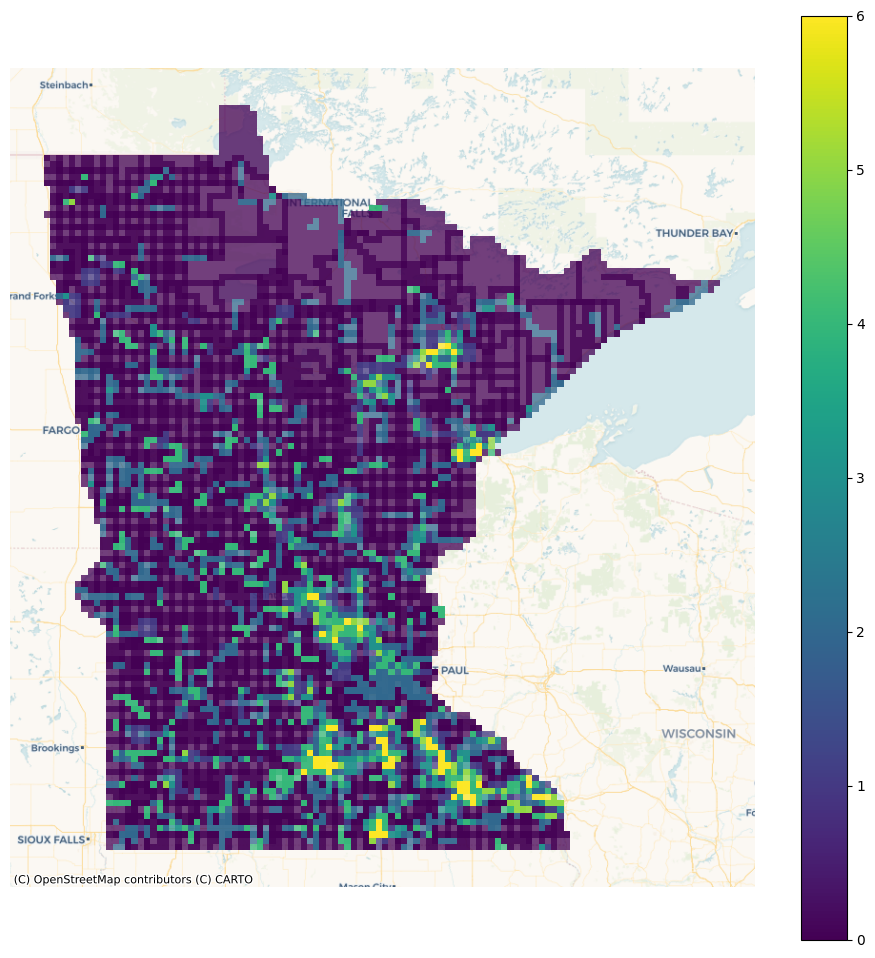

In [64]:
# Binary Agreement
grid["Binary_Total"] = grid["LISA_Binary"] + grid["Nwk_LISA_Binary_q_aadt"] + grid["Nwk_LISA_Binary_q_rl"] + grid["Nwk_LISA_Binary_f_aadt"] + grid["Nwk_LISA_Binary_f_rl"] + grid["ADBSCAN_Binary"]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

grid.plot(
    ax=ax,
    alpha=0.75,
    column="Binary_Total",
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()